In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
pip install -q git+https://github.com/tensorflow/examples.git

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow_examples.models.pix2pix import pix2pix
import cv2
from google.colab.patches import cv2_imshow
import os
import glob
import time
import matplotlib.pyplot as plt
from IPython.display import clear_output

AUTOTUNE = tf.data.AUTOTUNE

In [48]:
PATH = '/content/drive/MyDrive/Frames/Kaggle/img_align_celeba/Sample'

In [41]:
BUFFER_SIZE = 2000
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [42]:
def load(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image,channels=3)
  input_image = tf.cast(image, tf.float32)

  return input_image

In [43]:
def load_black(image_file):
  image = tf.io.read_file(image_file)
  image = tf.image.decode_jpeg(image,channels=3)
  image = tf.image.rgb_to_grayscale(image)
  input_image = tf.cast(image, tf.float32)
  image = tf.concat([input_image,input_image,input_image],2)

  return image

In [44]:
def normalize(input_image):
  input_image = (input_image / 127.5) - 1
  return input_image

In [45]:
def load_image_org(image_file):
  input_image = load(image_file)
  input_image = tf.image.resize(input_image, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image = normalize(input_image)

  return input_image

In [46]:
def load_image_black(image_file):
  input_image = load_black(image_file)
  input_image = tf.image.resize(input_image, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
  input_image = normalize(input_image)

  return input_image

In [49]:
train = tf.data.Dataset.list_files(PATH +'/00*.jpg')

In [50]:
train_color = train.map(load_image_org,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_color = train_color.shuffle(BUFFER_SIZE)
train_color = train_color.batch(BATCH_SIZE)

In [51]:
train_black = train.map(load_image_black,
                                  num_parallel_calls=tf.data.AUTOTUNE)
train_black = train_black.shuffle(BUFFER_SIZE)
train_black = train_black.batch(BATCH_SIZE)

In [ ]:
for img in train_black.take(1):
  plt.imshow(img.numpy()[0]*0.5+0.5)

In [54]:
sample = img

In [61]:
OUTPUT_CHANNELS = 3

generator_g = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')
generator_f = pix2pix.unet_generator(OUTPUT_CHANNELS, norm_type='instancenorm')

discriminator_x = pix2pix.discriminator(norm_type='instancenorm', target=False)
discriminator_y = pix2pix.discriminator(norm_type='instancenorm', target=False)

In [55]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [56]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [57]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [58]:
def calc_cycle_loss(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))

  return LAMBDA * loss1

In [59]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [60]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

In [ ]:
checkpoint_path = "drive/MyDrive/Frames/Kaggle/checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=1)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [13]:
def generate_images(model, test_input):
  prediction = model(test_input)

  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot it.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [62]:
@tf.function
def train_step(real_x, real_y):
  # persistent is set to True because the tape is used more than
  # once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    # calculate the loss
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)

    total_cycle_loss = calc_cycle_loss(real_x, cycled_x) + calc_cycle_loss(real_y, cycled_y)

    # Total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)
    
    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)

  # Calculate the gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)

  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  # Apply the gradients to the optimizer
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))

  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))

  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))
  return total_gen_g_loss,total_gen_f_loss

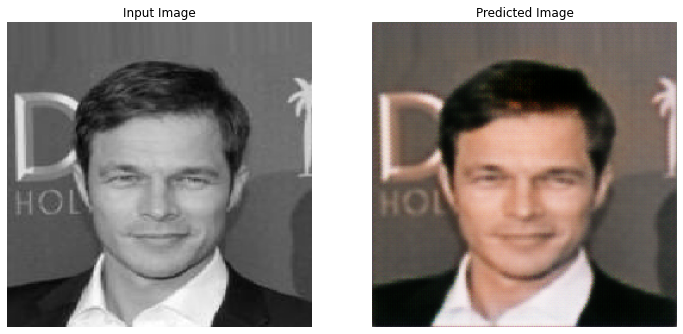

Time taken for epoch 18 is 52.96799874305725 sec



In [ ]:
EPOCHS = 40
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((train_black, train_color)):
    g,f = train_step(image_x, image_y)
    n+=1
    #if n % 100 == 0:
      #print ('.', end='')
    #if n%5000 == 0:
  
  generate_images(generator_g, sample)
      #ckpt_save_path = ckpt_manager.save()
      #print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,ckpt_save_path))
                                                         
  print ('Time taken for epoch {} is {} sec\n'.format(epoch+1,
                                                      time.time()-start))
  clear_output(wait=True)

In [35]:
image = cv2.imread('Abraham_Lincoln.jpg')
image = normalize(image)
image = tf.image.resize(image, [256, 256],
                                method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
image = tf.expand_dims(image,0)


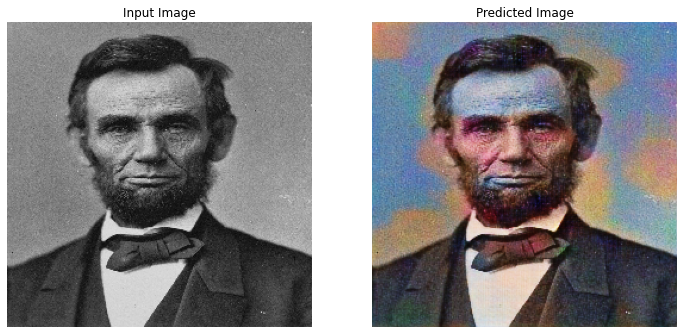

In [38]:
generate_images(generator_g,image)

In [39]:
for img in train_black.take(20):
    generate_images(generator_g, img)

NameError: ignored